# **PROBLEME II : Arbres de décision, une application sur des données réelles**


## **Analyse exploratoire descriptive du jeu de données :  5-Breast Cancer**

> Installation des packages et librairies, chargement de la base de données

In [ ]:
rm(list=ls())
install.packages('party')
install.packages('caret')
install.packages('rpart')
install.packages('rpart.plot')
install.packages('ggplot2')
install.packages('rattle')
install.packages('e1071')
install.packages("Metrics")
library(party)
library(caret)
library(rpart)
library(rpart.plot)
library(ggplot2)
library(rattle)
library(e1071)
library(Metrics)
library(pROC)
library(Rarity)

In [ ]:
BC <- read.csv('Winconsin.csv', sep=';')

Nous avons 10 parametres différents, avec 3 données pour chacun d'entre eux.
Ces parametres correspondent aux mesures prisent lors d'un examen cytologique de cellules dans le cadre d'un diagnostic de cancer du sein.
Nous retrouvons la moyenne en 1, l'écart type en 2, la valeur la plus large, ou pire valeur, en 3.
L'objectif de la récolte de ces données est donc de déterminer si les cellules récoltées sont bénignes ou cancéreuses : colonne 31 "Diagnosis'.



> Démarrons l'analyse



In [ ]:
str(BC)

Nous avons des données numériques continues pour tout les parametres sauf le diagnostic qui correspond aux caracteres B si Benin et M si Malin.

In [ ]:
parametres <- names(BC)[1:10]
print(parametres)
missing_values <- sapply(BC, function(x) sum(is.na(x)))
print(missing_values)

Nous pouvons retrouver les 10 parametres differents : radius, texture, perimeter, area, smoothness, compactness,concavity, concave points, symmetry and fractal dimension.


*  radius = correspond au rayon (moyen, ecart-type, et maximum) de la population de celulles.
*  texture = correspond à une analyse des images, et caractérise la surface et la structure interne des cellules. Ce parametre permet de donner des informations importantes sur l'état de la cellule.
*  perimeter = correspond au périmetre de la population de cellules (moyen, ecart-type et maximum).
*  areas = mesure de la taille de la cellule, généralement exprimée en unités de pixels ou en unités de surface. Une aire plus grande peut être associée à une pathologie avancée.
*   smoothness = représente la variation locale dans les longueurs de rayon des cellules. Une faible valeur indique une surface lisse, tandis qu'une valeur élevée indique une surface irrégulière.
*   compactness = Mesure à quel point la forme de la cellule est proche ou éloignée d'un cercle. Les formes plus circulaires ont une compacité faible, tandis que les formes plus complexes ou irrégulières ont une compacité élevée.
*   concavity = Évalue l'étendue des portions concaves de la frontière de la cellule. Une cellule avec beaucoup de concavités aura une valeur élevée pour ce paramètre.
*   concave points = Compte le nombre de points concaves sur le contour de la cellule. Plus il y a de points concaves, plus la valeur est élevée.
*   symmetry = Quantifie la symétrie de la cellule. Une forme parfaitement symétrique aura une valeur plus élevée, tandis qu'une asymétrie marquée donnera une valeur plus faible.
*   fractal dimension = Indique la complexité fractale de la frontière de la cellule, reflétant à quel point la forme est complexe et fragmentée. Plus la frontière est irrégulière, plus la dimension fractale est élevée.

Ces paramètres sont couramment appliqués lors d,un examen cytologique, notamment pour évaluer les caractéristiques des cellules dans des échantillons tels que ceux obtenus par frottis ou biopsie, afin de distinguer les cellules normales et pathologiques.

Dans notre base de données il n'y a aucune valeur manquantes.

In [ ]:
summary(BC)
table(BC$Diagnosis)

Nous avons 569 populations de cellules.
Parmis les 569 observations, 357 ont été classées bénignes, et 212 malignes, autrement dit cancéreuses. Nous allons effectuer des analyses sur la moyenne des parametres, donc sur les valeurs des colonnes 1 a 10.
Nous voulons savoir l'ordre de grandeur des valeurs par parametres, pour pouvoir visualiser les variables de tailles similaires ensemble.

In [ ]:
max_val <- apply(BC[, 1:10], 2, max)
ordegrandeur<- floor(log10(max_val))
print(ordegrandeur)

par(mfrow=c(1,5))
boxplot(BC[, 1:2], main="Boxplots of Columns 1 and 2", las=2)
boxplot(BC[, 3], main="Boxplots of Column 3 = mean perimeters", las=2)
boxplot(BC[, 4], main="Boxplots of Column 4 = mean area ", las=2)
boxplot(BC[, 5:9], main="Boxplots of Columns 5 to 9", las=2)
boxplot(BC[, 10], main="Boxplots of Column 10 = mean fractal dimension", las=2)
par(mfrow=c(1,1))

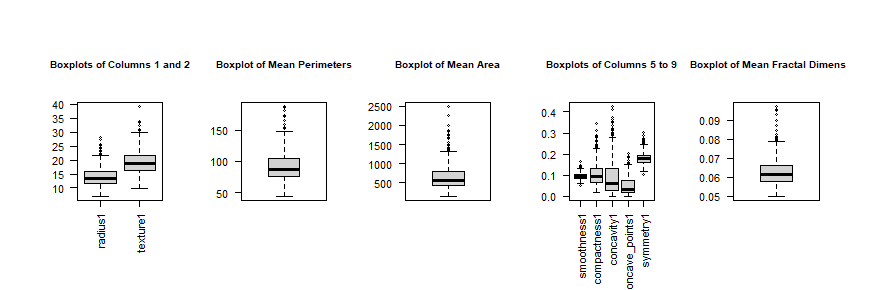

Nous pouvons maintenant visualiser les differents boxplots.Nous pouvons observer de nombreuses valeurs aberrantes, se situant en dehors des moustaches.

Nous observons ces valeurs pour des données supérieures uniquement, et non inférieures.

Ces valeurs peuvent correspondre à des cellules cancéreuses, dont la moyenne des differents parametres differe alors de la gamme typique des données, a savoir des cellules "normales".

D'autant plus, nous savons que lorsque les cellules deviennent cancéreuses, celles-ci se développent de maniere non controlée et sont donc en genereal plus grosse que la normale.

Juste pour voir, comptons ces valeurs abberantes

In [ ]:
Val_AB <- sapply(BC[, 1:10], function(col) {
  if (is.numeric(col)) {
    Q1 <- quantile(col, 0.25, na.rm = TRUE)
    Q3 <- quantile(col, 0.75, na.rm = TRUE)
    IQR <- Q3 - Q1
    lower_bound <- Q1 - 1.5 * IQR
    upper_bound <- Q3 + 1.5 * IQR
    return(sum(col < lower_bound | col > upper_bound, na.rm = TRUE))
  } else {
    return(NA)
  }
})
sum(Val_AB)

Nous savons que 212 observations ont été classées malignes,et nous avons 139 valeurs abberantes, cela pourrait coller.
Sachant que nous avons effectué l'analyse que sur la moyenne.



> Corrélation des différents parametres



In [ ]:
cor_matrice <- cor(BC[, sapply(BC, is.numeric)])
print(cor_matrice)
corPlot(cor_matrice[,1:10], method = "pearson")

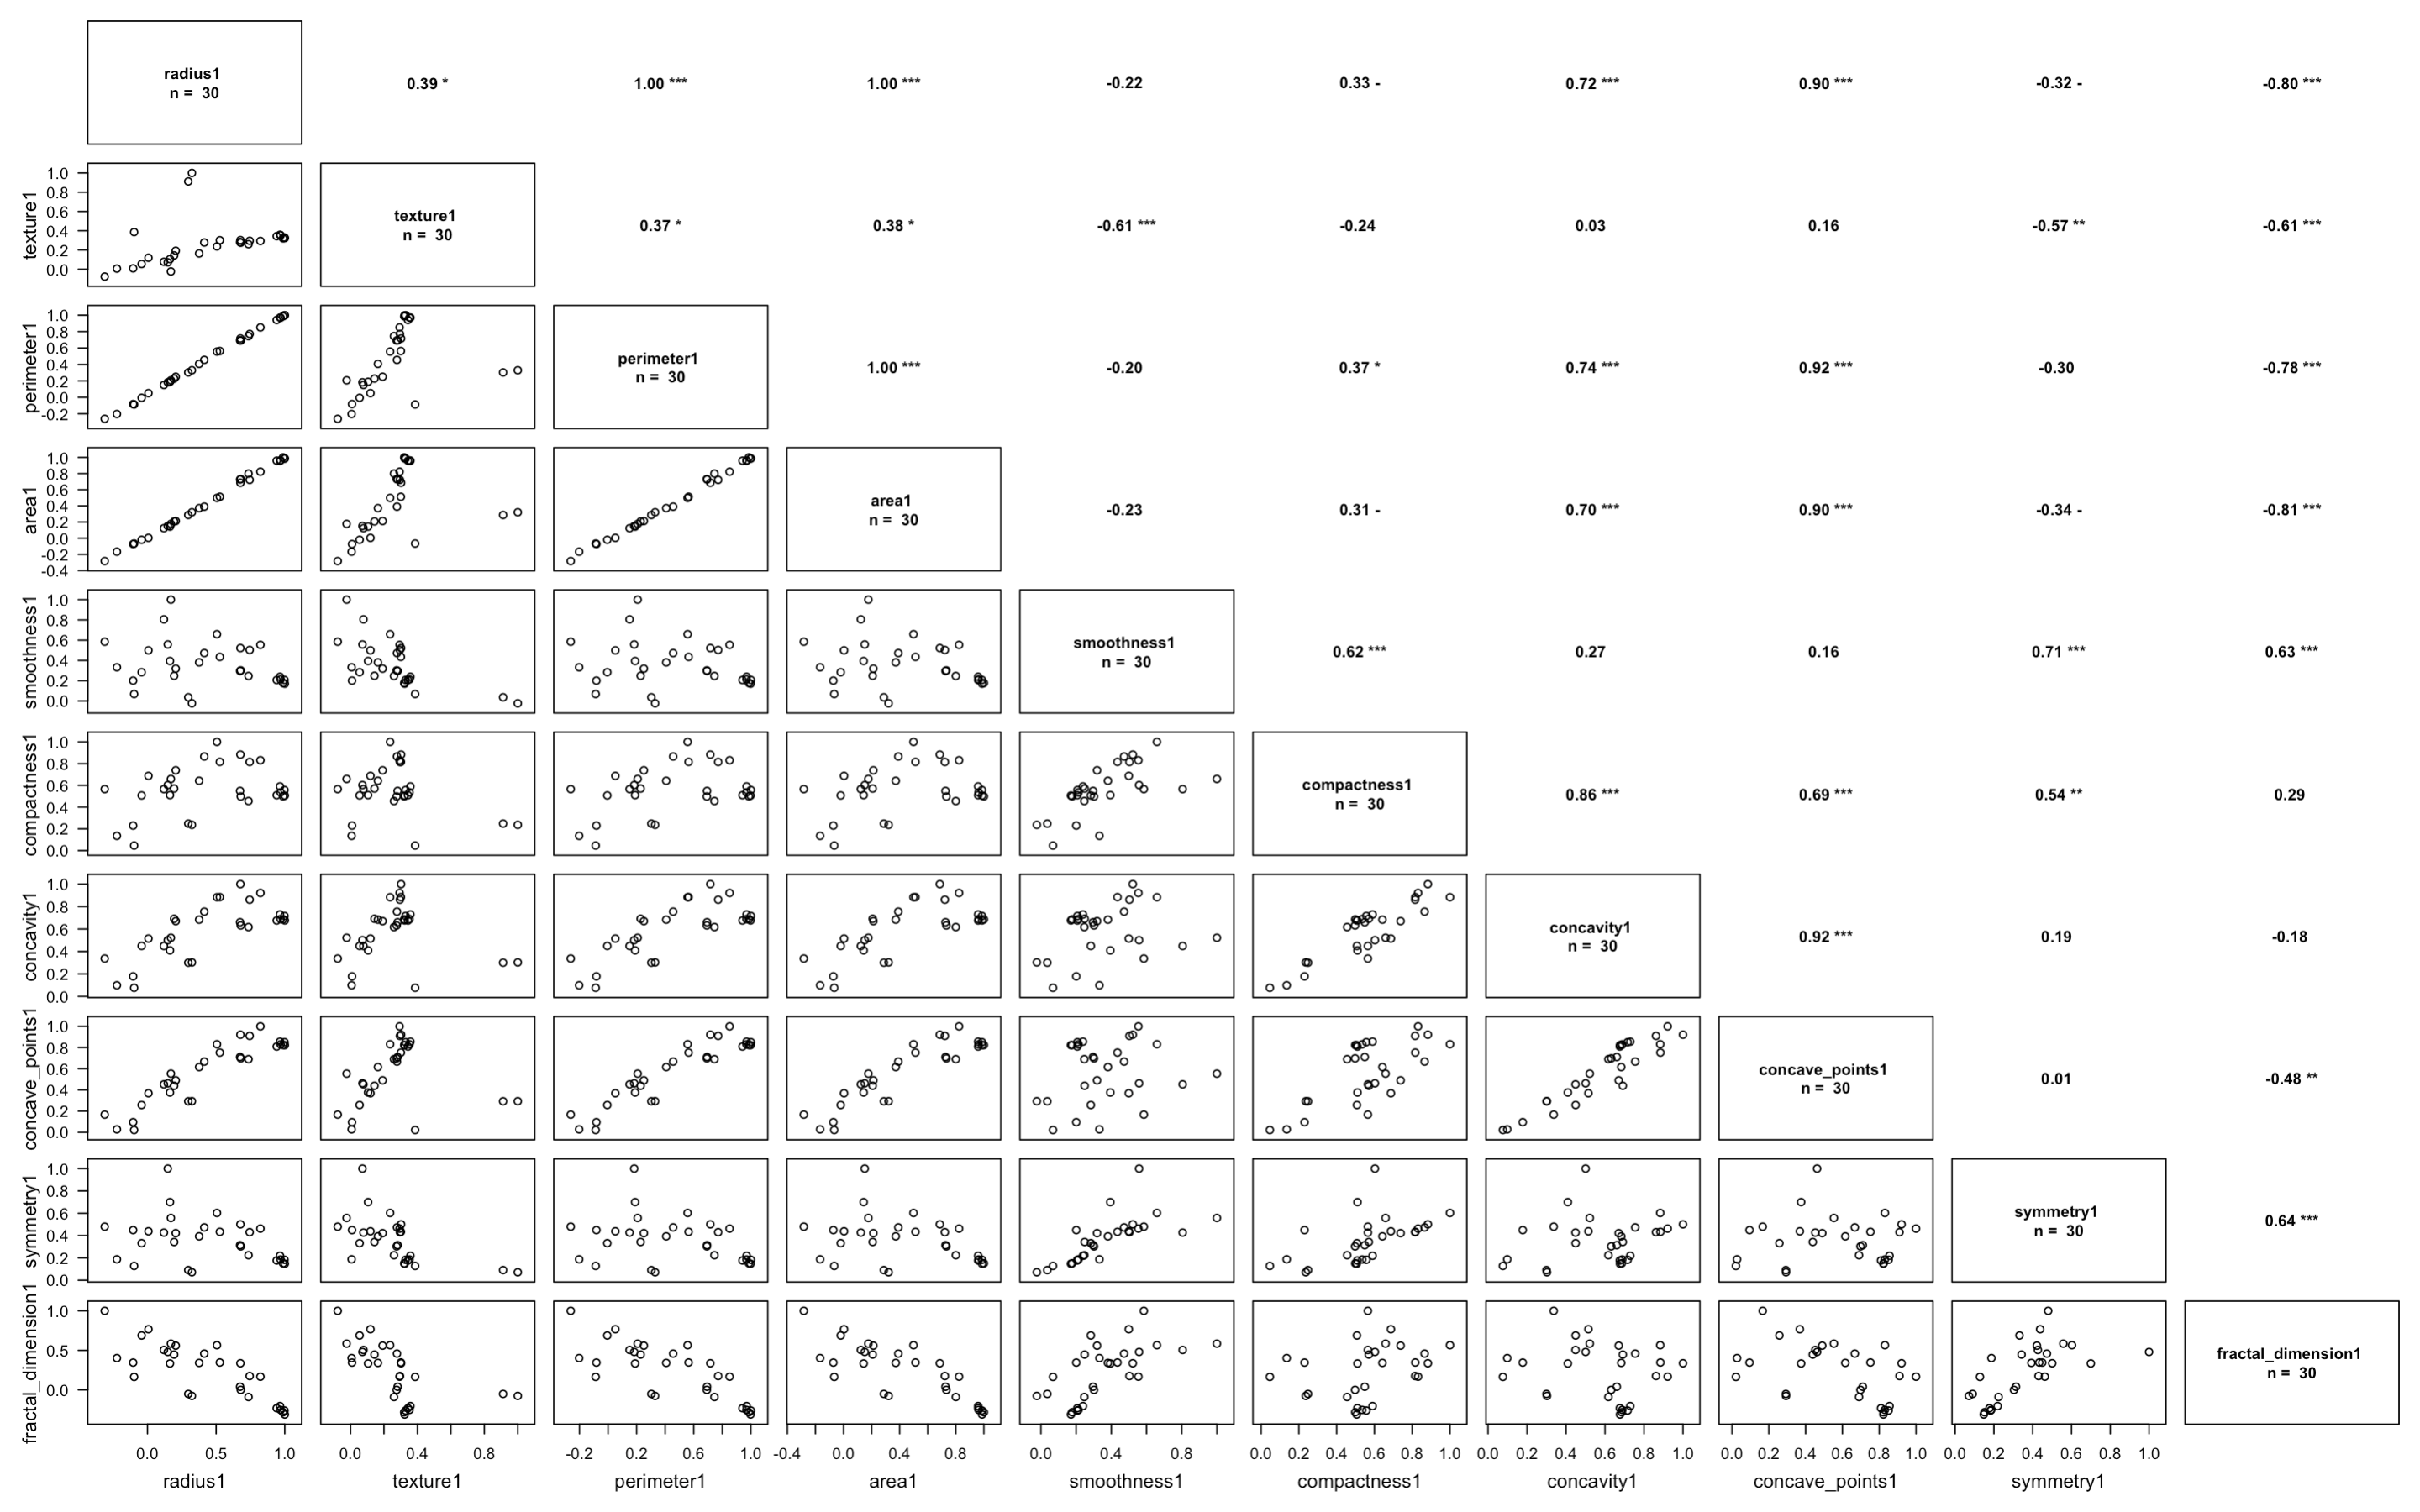

radius1, perimeter1, et area1 sont fortement corrélés entre eux (proches de 1), ce qui est logique car le périmètre et la surface sont dérivés du rayon.

Les caractéristiques comme compactness1, concavity1, et concave_points1 montrent également une forte corrélation entre elles. Elles correspondent toutes à des mesures de forme.

Tout ces resultats sont cohérents avec le type de données que nous traitons.



> Distribution des parametres



In [ ]:
skewness_vals <- sapply(BC[, sapply(BC, is.numeric)], skewness)
kurtosis_vals <- sapply(BC[, sapply(BC, is.numeric)], kurtosis)
print(skewness_vals[1:10])
print(kurtosis_vals[1:10])

Les 10 premières colonnes présentent une asymétrie positive, ce qui signifie que leurs distributions sont étirées vers la droite, soit vers des valeurs supérieures.

La plupart des colonnes sont plus pointues que la distribution normale.

Cohérent avec nos résultats précédant, nous avons des valeurs aberrantes dans notre échantillon.

## **Construction du classifieur**

La variable dépendante ici est la valeur 'Diagnosis'. Nous voulons donc prédire avec les différents parametres si la cellule est benigne ou maligne. Nous gardons tous les autres parametres pour la prédiction.

> Division des données, et définition de la classe positive



In [ ]:
set.seed(123)
splitIndex <- createDataPartition(BC$Diagnosis, p = 0.7, list = FALSE)
trainData <- BC[splitIndex, ]
testData <- BC[-splitIndex, ]
trainData$Diagnosis <- factor(trainData$Diagnosis, levels = c("M", "B"))
testData$Diagnosis <- factor(testData$Diagnosis, levels = c("M", "B"))

> Construction et optimisation de l'arbre en utilisant la validation croisée, puis en effectuant un élaguage

In [ ]:
fitControl <- trainControl(method = "cv", number = 10)
fit <- train(Diagnosis ~ ., data=trainData, method="rpart", trControl=fitControl,
             tuneGrid=data.frame(cp=seq(0.01, 0.5, 0.01)))
best_cp <- fit$bestTune$cp
tree <- rpart(Diagnosis ~ ., data=trainData, cp=best_cp)

> Visualisation de l'arbre

In [ ]:
rpart.plot(tree)
print(tree)

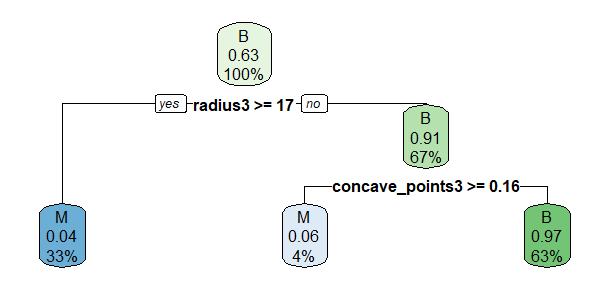

Nous pouvons interpéter cet arbre de la maniere suivante : dans la population totale 63% des populations sont bénines. On a donc une prédominance des cas bénins.

La premiere décision est prise sur le maximun du parametres radius, soit sur la valeur maximale du rayon. Si ce rayon est supérieur ou égal à 17,  la classe prédite est maligne pour 96% des cas. Si le rayon est inférieur, une deuxieme décision est prise.

La deuxieme décision est la suivante : si le nombre de points concaves est supérieur à 0,16 alors la classe prédite est maligne dans 94% des cas. Sinon, si le nombre de point concaves est inférieur à 0,16, alors la classe prédite est bénin dans 97% des cas.

Une valeur de rayon élevé indique une malignité mais l'information seule n'est pas suffisante dans le cas ou le radius est inférieur à 17. Ainsi, associée à la valeur de points concaves, cela nous permet d'estimer si la population est maligne ou bénine.






> Prédictions avec un seuil de décision par défaut à 0,5



In [ ]:
predictions <- predict(tree, testData, type = "class")



> On recherche le meilleur seuil de décision pour maximiser la sensibilité


L'objectif de ces prédictions est de prévoir un diagnostic de cancer du sein. Le diagnostic étant réalisé lorsqu'il y a des soupcons, nous souhaitons maximiser le nombre de personnes ayant un test positif et ayant réellement un cancer du sein, quitte à avoir des faux positifs. En effet, l'impact d'un faux positif, bien que boulversant pour un patient, est moindre par rapport à un faux négatif, qui retarderait la prise en charge d'un patient atteint de cancer du sein.

In [ ]:
roc_result <- roc(testData$Diagnosis, predict(tree, newdata = testData, type = "prob")[, 2], levels = c("B", "M"))
plot(roc_result)
roc_coords <- coords(roc_result, "all", ret = c("threshold", "sensitivity", "specificity"))
filtered_coords <- roc_coords[roc_coords$threshold >= 0 & roc_coords$threshold <= 1, ]
optimal_coords <- filtered_coords[which.max(filtered_coords$sensitivity), ]
optimal_threshold <- optimal_coords$threshold
optimal_sensitivity <- optimal_coords$sensitivity
optimal_sensitivity
optimal_threshold


La meilleur sensitivié obtenu est d'environ 89% pour un seuil de décision de 0,51. Autrement dit, nous obtenons le meilleur résultat de sensitivité avec le seuil par défaut, ce que nous avons réalisé précédemment.

## **Evaluation du classifieur**



> Matrice de confusion



La matrice de confusion nous permet d'évaluer la performance de notre modele.

In [ ]:
cm <- confusionMatrix(predictions, testData$Diagnosis)
print(cm)

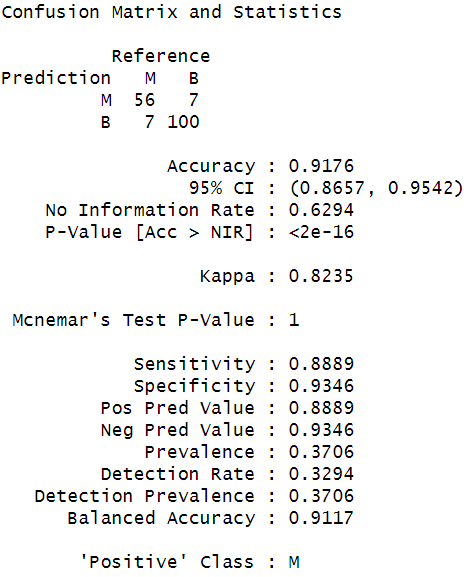

Notre modele a un taux d'exactitude d'environ 0.92 (Accuracy), avec un intervalle de confiance a 95% entre 0,87 et 0,95, ce qui est assez elevé. Le modèle a correctement identifié envrion 89% des tumeurs bénignes (Sensitivity), et 94% des tumeurs malignes (Specificity).
L'objectif de ce diagnostic étant de ne pas passer a coté d'un cancer, il aurait été préférable d'avoir une sensibilité plus élevé.

Nous avons 7 faux negatifs et 7 faux positifs, ce qui entraine une VPP = 89% (Pos Pred Value) et une VPN = 94% (Nef Pred Value).

La P-value, tres basse, suggère que la précision du modèle est significativement meilleure que celle d'un modèle sans information.

Le coefficient Kappa mesure l'accord entre les prédictions et les références au-delà de l'accord dû au hasard. Notre valeur de 0,8 est considéré comme un tres bon accord.

Le test de Mcnemar évalue l'équilibre des erreurs de classification (faux positifs et faux négatifs). Ici, il n'y a pas de déséquilibre significatif, le modèle se trompe de manière égale en prédisant les deux classes.

Nous avons une prévalence de 37% de cas malins dans l'ensemble des données, ce que prevoit également notre modele (Detection Prevalence), avec un taux de détection de 33% dans la population totale.

Enfin, Balanced Accuracy correspond à la moyenne de la sensibilité et de la spécificité, et prend en compte le déséquilibre des classes.



> Courbe ROC



In [ ]:
roc_obj <- roc(testData$Diagnosis, as.numeric(predictions))
plot.roc(roc_obj, main="Courbe ROC", col="blue")
auc(roc_obj)

Nous avons une aire sous la courbe de 0,9117. Cela signifie que le modèle a une très bonne capacité à distinguer les tumeurs bénignes des tumeurs malignes. Une AUC supérieure à 0.9 est généralement considérée comme excellente, indiquant que le modèle a une forte probabilité de classer correctement une observation au hasard par rapport à sa véritable classe.

Dans le contexte : avoir une telle capacité de distinction est crucial, car cela pourrait conduire à de meilleures décisions cliniques et, à de meilleurs résultats pour les patients.



> Conclusion générale



En conclusion, notre modele est un tres bon modele permettant, a partir d'une population de cellules et avec les parametres recoltés lors d'une biopsie ou d'un frottis, de prédire si leur provenance est d'origine malignes ou bénines.

En situation réelle, l'examen cytologique des cellules est réalisé pour confirmer le diagnostic à la suite de différents signes cliniques assez evocateurs de la pathologie : nodule palpable, écoulements, mais aussi à la suite d'un examen radiologique ou une anomalie est visible.

Source : https://www.has-sante.fr/upload/docs/application/pdf/2015-04/refces_k_du_sein_vf.pdf

En comparaison, la specificité du programme national de dépistage du cancer du sein à l'aide d'une mammographie a une sensibilité de 82,8% et une spécificité de 91,4%.

Source : https://www.santepubliquefrance.fr/maladies-et-traumatismes/cancers/cancer-du-sein/documents/article/sensibilite-et-specificite-du-programme-de-depistage-organise-du-cancer-du-sein-a-partir-des-donnees-de-cinq-departements-francais-2002-2006


# **PROBLEME III :**


**Question 1**



La courbe LIFT permet de comparer l'efficacité d'un modèle de classification à une sélection aléatoire. C'est une mesure du gain apporté par le modèle par rapport à une stratégie aléatoire.



L'expression mathématique pour calculer le LIFT en fonction de RPP (Taux de Prédictions Positives) et Se (Sensibilité) est : **LIFT =  Se /RPP**

**Explication dans le contexte de l'exercice:**


En utilisant la formule ci-dessus, le banquier peut évaluer l'efficacité de son modèle de prédiction. Si le LIFT est supérieur à 1, cela signifie que le modèle fait mieux que le hasard. Si le LIFT est inférieur à 1, le modèle est moins performant que le hasard.


**Question 2**

En utilisant les données fournies dans l'énoncé et en se concentrant sur le groupe G2 des bons clients, nous avons établi le tableau de seuil optimal Topt et les scores associés pour déterminer la sensibilité.

Le tableau ci-dessous présente les différents seuils de scores, le nombre d'individus correspondant à chaque seuil, la proportion de réponses positives prévues (RPP) et la sensibilité (Se) pour chaque seuil :

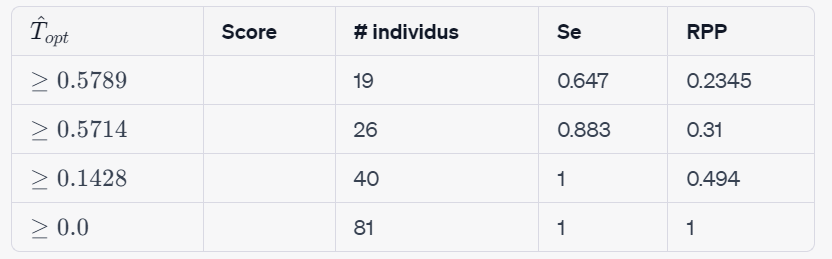

**Analyse :**  Le tableau présenté illustre les performances d'un classifieur en fonction de différents seuils de décision Topt. L'objectif est de maximiser la capacité du classifieur à détecter les vrais bons clients (Se) tout en gardant un taux de prédictions positives (RPP) raisonnable afin de ne pas surcharger le système avec trop de faux positifs.

Pour un seuil de **Topt ≥ 0.5789**, nous observons une **sensibilité de 64.7% avec un RPP de 23.45%**. Cela signifie que le classifieur identifie correctement environ deux bons clients sur trois mais limite considérablement le nombre de clients contactés.

En abaissant le seuil à **Topt ≥ 0.5714**, l**a sensibilité augmente à 88.3%, et le RPP à 31%**. Cet ajustement du seuil suggère qu'un plus grand nombre de bons clients sont identifiés, mais avec une légère augmentation du risque de prédire à tort un mauvais client comme bon.

Lorsque le seuil est encore abaissé à  **Topt ≥ 0.1428**, nous atteignons **une sensibilité parfaite de 100%**, indiquant que tous les vrais bons clients sont identifiés. Cependant, cela se fait au prix d'un RPP élevé de 49.4%, indiquant que presque la moitié des clients évalués sont classés comme positifs, augmentant ainsi le risque de cibler de nombreux mauvais clients.

À un seuil de **Topt ≥ 0.0**, tout individu est prédit comme un bon client, ce qui conduit à une sensibilité et un RPP de 1, ce qui n'est pas pratique dans un scénario réel.

L'analyse des chiffres suggère que le choix du seuil de classification doit être soigneusement équilibré. Un seuil trop élevé risque d'exclure de nombreux bons clients, tandis qu'un seuil trop bas augmente le risque financier lié à l'acquisition de clients potentiellement non rentables.

L'objectif pour le banquier serait de choisir un seuil qui maximise la sensibilité tout en maintenant le RPP à un niveau acceptable pour la banque, en prenant en considération les coûts associés à l'acquisition de faux positifs par rapport aux revenus générés par les vrais bons clients.

**Question 3 :**

La courbe LIFT illustre le rapport entre le taux de réponse positif (RPP) obtenu par un modèle de prédiction et le taux de réponse positif que l'on aurait obtenu en contactant les individus au hasard. Elle est utile pour évaluer l'efficacité d'un modèle.

In [ ]:

# Définir les données
se_values <- c(0, 1, 0.647, 0.883, 1)     # RPP
rpp_values <- c(0, 1, 0.2345, 0.31, 0.494)  # Se

# Créer un data frame avec les valeurs RPP et Se
data <- data.frame(RPP = rpp_values, Se = se_values)

# Créer le graphique avec une courbe d'interpolation polynomiale
lift_plot <- ggplot(data, aes(x = RPP, y = Se)) +
  geom_point() +  # ajoute les points
  geom_smooth(method = 'lm', formula = y ~ poly(x,3 ), se = FALSE) +  # ajoute une courbe polynomiale
  xlim(0, 1) +  # limite de l'axe des x
  ylim(0, 1) +  # limite de l'axe des y
  xlab("RPP (Rate of Positive Predictions)") +  # étiquette de l'axe des x
  ylab("Se (Sensibility)") +  # étiquette de l'axe des y
  ggtitle("Courbe LIFT") +  # titre du graphique
  theme_minimal()  # thème minimal pour le graphique

# Afficher la courbe LIFT
print(lift_plot)


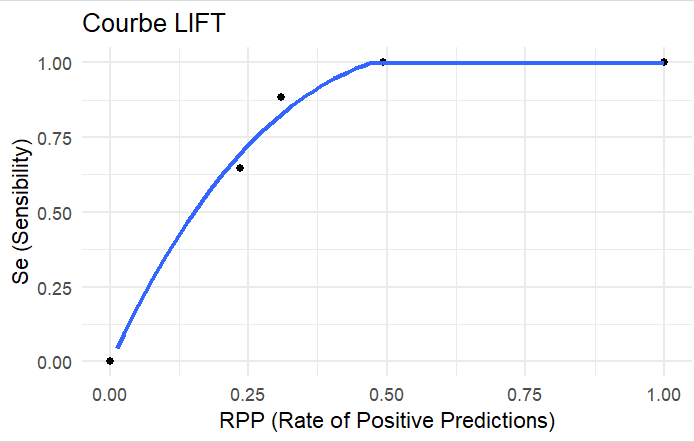

**Analyse**   
Il est crucial pour le banquier de comprendre que plus le LIFT est élevé, plus le modèle est efficace pour cibler les bons clients. Un LIFT de 1 indique que le modèle ne fait pas mieux que le hasard, tandis qu'un LIFT supérieur à 1 montre l'efficacité du modèle par rapport à une sélection aléatoire.

**Question 4**



In [ ]:
lift_plot <- ggplot(data, aes(x = RPP, y = Se)) +
  geom_point() +  # ajoute les points
  geom_smooth(method = 'lm', formula = y ~ poly(x, 3), se = FALSE) +  # ajoute une courbe polynomiale
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "blue") +  # ajoute la première bissectrice
  xlim(0, 1) +  # limite de l'axe des x
  ylim(0, 1) +  # limite de l'axe des y
  xlab("RPP (Rate of Positive Predictions)") +  # étiquette de l'axe des x
  ylab("Se (Sensibility)") +  # étiquette de l'axe des y
  ggtitle("Courbe LIFT") +  # titre du graphique
  theme_minimal()  # thème minimal pour le graphique

# Afficher la courbe LIFT
print(lift_plot)

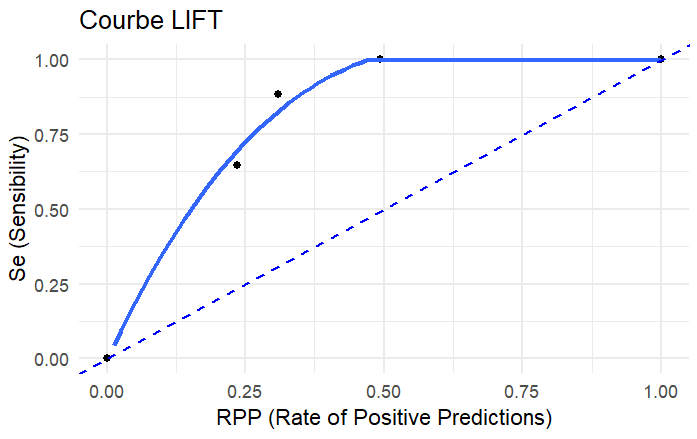

**Analyse:**

Les points sur la bissectrice indiquent une performance de prédiction équivalente à une sélection aléatoire. Il n'y a pas de gain d'information ou d'avantage à utiliser le modèle par rapport à un choix aléatoire.

Les points se trouvant au-dessus de cette ligne, indique un modèle avec un pouvoir prédictif supérieur à la chance, capable d'identifier les bons clients avec une plus grande efficacité.


**Conclusion**

Cela signifie que le modèle est utile pour identifier les bons clients avec une plus grande précision que ce que l'on obtiendrait en sélectionnant des clients sans aucun modèle, c'est-à-dire au hasard.

La courbe LIFT ici montre que le modèle utilisé par le banquier est capable d'identifier les bons clients mieux qu'une sélection aléatoire. Cela indique que le modèle de scoring ou de classification utilisé est efficace pour cibler les "bons" clients.

Étant donné que le modèle est efficace, le banquier peut utiliser ses ressources plus efficacement. Plutôt que de contacter tous les clients ou de choisir des clients au hasard, le banquier peut se concentrer sur ceux que le modèle prédit comme étant de bons clients, ce qui peut se traduire par une réduction des coûts de communication et de marketing ce que nous allons chercher à faire par la suite.

**Question 5**



In [ ]:
# Définir les données
se_values <- c(0, 1, 0.647, 0.883, 1)     # Se
rpp_values <- c(0, 1, 0.2345, 0.31, 0.494)  # RPP

# Créer un data frame avec les valeurs RPP et Se
data <- data.frame(RPP = rpp_values, Se = se_values)

# Ajuster un modèle de régression polynomiale
model <- lm(Se ~ poly(RPP, 2), data = data)

# Utiliser le modèle pour prédire la valeur de Se pour RPP = 0.1 (10%)
predicted_se <- predict(model, newdata = data.frame(RPP = 0.1))

# Créer le graphique avec les annotations
lift_plot <- ggplot(data, aes(x = RPP, y = Se)) +
  geom_point() +
  geom_smooth(method = 'lm', formula = y ~ poly(x, 2), se = FALSE) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "blue") +
  geom_point(aes(x = 0.1, y = predicted_se), color = "red", size = 3) +
  annotate("text", x = 0.1, y = predicted_se, label = paste("Lift à 10%:", round(predicted_se, 2)), vjust = -1) +
  xlim(0, 1) +
  ylim(0, 1) +
  xlab("RPP (Rate of Positive Predictions)") +
  ylab("Se (Sensibility)") +
  ggtitle("Courbe LIFT") +
  theme_minimal()

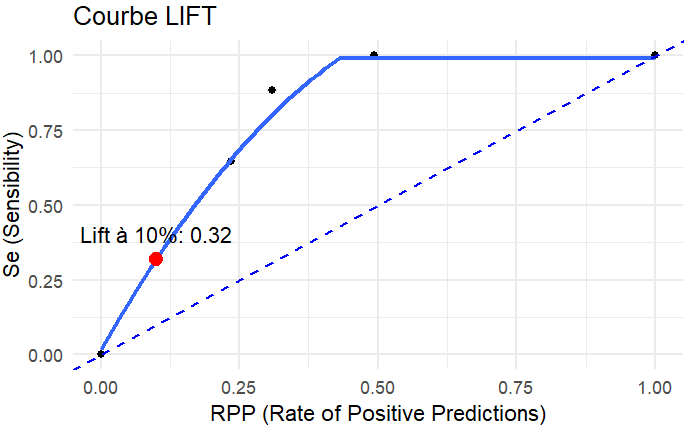

**Analyse**

**Valeur de Lift:** Un lift de **0.32** à 10% signifie que, par rapport à une sélection aléatoire, le modèle améliore la sensibilité par un facteur de 0.32 à ce seuil. Cela indique une amélioration par rapport au hasard, mais pas nécessairement une forte performance. Dans un contexte idéal, le lift serait plus proche de 1 ou au-delà, indiquant que le modèle est significativement meilleur que le hasard pour identifier les vrais positifs.

**Sélection des candidats:** Si le banquier utilise ce modèle, en ciblant les 10% des candidats avec les scores les plus élevés, il/elle capturerait 32% de tous les vrais positifs possibles (si l'on suppose que 1.0 représente une capture de 100% des vrais positifs). Cela peut être utile si les ressources pour approfondir ou accorder des prêts sont limitées et doivent être concentrées sur les candidats les plus prometteurs.

**Performance du modèle:** Bien que le modèle ait une certaine capacité à classer les vrais positifs mieux que le hasard, la performance à ce seuil n'est pas exceptionnelle. Le banquier pourrait rechercher une meilleure performance avant de dépendre fortement de ce modèle pour les décisions de l'envoi de son offre.

**Question 6**

**1) Mesure de Performance:**

**Courbe ROC**: La courbe ROC est un graphique de la sensibilité (ou taux de vrais positifs) contre 1-spécificité (ou taux de faux positifs) à différents seuils de classification. Elle est indépendante de la distribution de classe et mesure la capacité d'un modèle à distinguer entre les classes pour tous les seuils de classification possibles.

**Courbe LIFT:** La courbe LIFT compare le taux de réponses positives (c'est-à-dire, le taux de vrais positifs) à un certain pourcentage des meilleurs scores prédits par le modèle, par rapport à ce même pourcentage dans un modèle de référence ou une sélection aléatoire. Elle se concentre davantage sur la performance du modèle dans le segment supérieur de prédictions et est sensible à la distribution de classe.

**2)Interprétation et Utilisation:**

**Courbe ROC:** La courbe ROC est souvent utilisée dans des contextes où les coûts de faux positifs et de faux négatifs sont de préoccupation, et où l'on cherche un bon équilibre entre sensibilité et spécificité sans se préoccuper directement de la prévalence des classes.

**Courbe LIFT:** La courbe LIFT est utile dans des scénarios marketing et de détection de fraude où l'on s'intéresse particulièrement à la capture d'une haute proportion de cas positifs (comme les clients les plus susceptibles de répondre à une campagne ou les transactions les plus susceptibles d'être frauduleuses) parmi un petit segment ciblé. Elle est particulièrement utile pour l'évaluation de la performance du modèle sur le "top-n" prédictions.


Ainsi ces différences rendent ces courbes adaptées à différentes situations d'évaluation de modèle, avec la courbe ROC étant plus générale et la courbe LIFT étant ciblée pour des applications spécifiques où les meilleurs scores sont de la plus grande importance.

**Question 7**


In [ ]:
# Calculer Se normalisé par RPP
normalized_se <- se_values / rpp_values
normalized_se[is.infinite(normalized_se)] <- NA  # Remplacer les infinis par NA pour éviter les erreurs graphiques

# Créer un dataframe pour ggplot
data <- data.frame(RPP = rpp_values, NormalizedSe = normalized_se)

# Tracer la courbe LIFT normalisée
ggplot(data, aes(x = RPP, y = NormalizedSe)) +
  geom_point() +  # Ajouter les points
  geom_line() +  # Ajouter une ligne pour relier les points
  geom_hline(yintercept = 1, linetype = "dashed") +  # Ajouter une ligne horizontale en pointillés à y = 1
  xlim(0, 1) +  # Limite de l'axe des abscisses
  ylim(0, max(normalized_se, na.rm = TRUE)) +  # Limite de l'axe des ordonnées
  xlab("RPP (Rate of Positive Predictions)") +  # Étiquette de l'axe des abscisses
  ylab("Normalized Se (Sensitivity)") +  # Étiquette de l'axe des ordonnées
  ggtitle("Courbe LIFT normalisée") +  # Titre du graphique
  theme_minimal()  # Utiliser un thème minimaliste pour le graphique



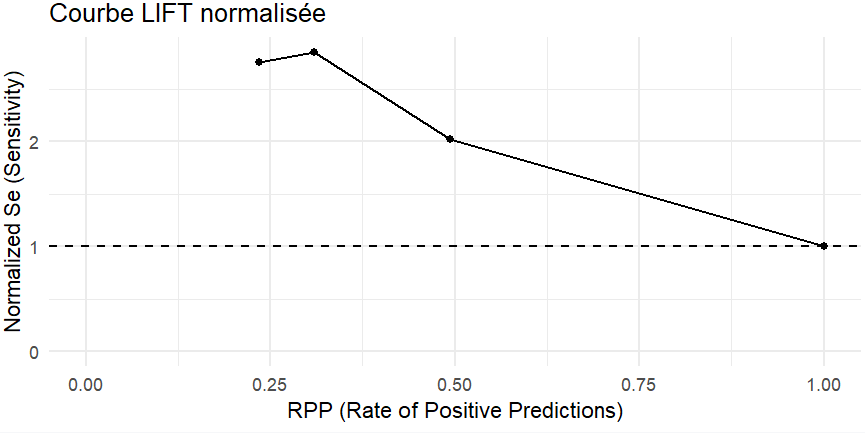

En ajoutant une interpolation avec un polynome d'ordre 2, on obtient :

In [ ]:
ggplot(data, aes(x = RPP, y = NormalizedSe)) +
  geom_point() +  # Ajouter les points
  geom_smooth(method = "lm", formula = y ~ poly(x, 2), color = "blue") +  # Ajouter une courbe d'interpolation polynomiale d'ordre 3
  geom_hline(yintercept = 1, linetype = "dashed") +  # Ajouter une ligne horizontale en pointillés à y = 1
  xlim(0, 1) +  # Limite de l'axe des abscisses
  ylim(0, max(normalized_se, na.rm = TRUE)) +  # Limite de l'axe des ordonnées
  xlab("RPP (Rate of Positive Predictions)") +  # Étiquette de l'axe des abscisses
  ylab("Normalized Se (Sensitivity)") +  # Étiquette de l'axe des ordonnées
  ggtitle("Courbe LIFT normalisée avec interpolation polynomiale") +  # Titre du graphique
  theme_minimal()  # Utiliser un thème minimaliste pour le graphique


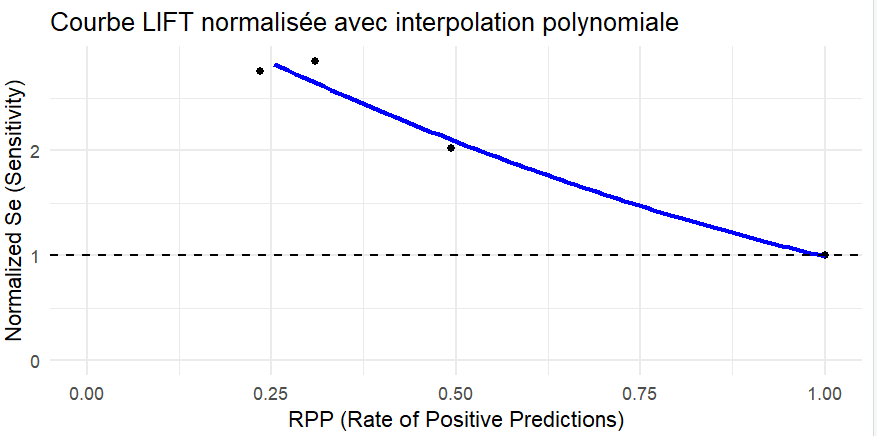

Nous remarquons que la courbe normalisée décroît au fur et à mesure que le RPP augmente, indiquant que la sensibilité relative diminue par rapport à la proportion de prédictions positives. Ce phénomène est attendu dans une courbe LIFT normalisée, car à mesure que l'on abaisse le seuil pour inclure plus de prédictions positives, l'efficacité du modèle à capturer les vrais positifs par rapport à une sélection aléatoire tend à diminuer.

En conclusion, cela peut être interprété comme une indication que le modèle a une bonne capacité à distinguer entre les classes positives et négatives à des seuils de classification élevés, mais cette capacité s'atténue à mesure que l'on accepte davantage de faux positifs en abaissant le seuil.



**Question 8**

À un LIFT de 23%, rejoindre 11 bons clients coûte 19 euros, ce qui revient à 1.73 euros par bon client.

Un LIFT de 30% correspond à un ratio de 2.75.
Avec un LIFT de 30%, chaque client bon trouvé coûte 1 /2.75 de l'effort de contact, car le LIFT est le ratio de l'efficacité du modèle par rapport à un choix aléatoire.

Cependant, si le coût par contact est constant (1.73 euros par bon client à un LIFT de 23%), alors le coût pour rejoindre un bon client à un LIFT de 30% serait le même en euros, car le LIFT est une mesure de l'efficacité relative et non une mesure des coûts absolus.

Cela dit, pour calculer le coût supplémentaire de rejoindre trois bons clients supplémentaires à un LIFT de 30%, nous supposerons que le coût par bon client reste constant à 1.73 euros.

Ainsi, pour rejoindre trois bons clients supplémentaires, cela coûterait :
3 bons clients×1.73 euros par bon client
=**5.19 euros**


Le résultat peut être interprété comme suit : même si l'efficacité du modèle augmente à un LIFT de 30%, le coût pour atteindre chaque bon client reste le même (si on suppose que le coût par contact ne change pas). Par conséquent, pour rejoindre trois bons clients supplémentaires, il en coûterait 5.19 euros supplémentaires. Cela illustre que, bien que le modèle soit plus efficace, le coût par client acquis n'a pas diminué dans cet exemple, reflétant le fait que l'efficacité accrue se traduit par la nécessité de contacter moins de personnes au total pour atteindre le même nombre de bons clients, mais ne change pas nécessairement le coût associé à chaque acquisition de client.

**Question 9**
**a)**

Pour répondre à cette question sans utiliser de modèle de prédiction, on suppose que la répartition des "bons" et "mauvais" clients est aléatoire. Si le vendeur souhaite atteindre 80 % de la clientèle considérée comme de "bons clients", et en l'absence de toute information supplémentaire pour différencier les bons des mauvais, il devrait théoriquement contacter 80 % de la totalité de sa clientèle. Cela s'appuie sur la loi des grands nombres, qui stipule qu'une grande suffisamment grande de clients contactés au hasard devrait, en moyenne, refléter la proportion de bons clients dans la population générale.


**question 9 b)**

In [ ]:
# Interpolation linéaire pour trouver Se (Sensibilité) pour plusieurs valeurs de RPP
rpp_range <- seq(0, 1, by = 0.01)  # Création d'une séquence de RPP de 0 à 1
se_interpolated <- approx(rpp_values, se_values, xout = rpp_range)$y

# Calcul de LIFT pour chaque RPP dans le rpp_range
lift_values <- se_interpolated / rpp_range
lift_values[is.infinite(lift_values)] <- NA  # Remplacer les infinis par NA pour éviter les erreurs graphiques



# Créer un dataframe pour le LIFT à différentes valeurs de RPP
lift_data <- data.frame(RPP = rpp_range, Lift = lift_values)

# Trouver le RPP le plus bas pour lequel le Lift est suffisant pour toucher 80% des bons clients
# On veut Lift * RPP >= 0.80
required_lift <- 0.80 / rpp_range
closest_rpp_index <- which.min(abs(lift_values - required_lift))
closest_rpp <- rpp_range[closest_rpp_index]

# Répondre à la question 9b
print(paste("Pour toucher 80% des bons clients en utilisant la courbe LIFT, le vendeur devrait contacter environ", round(closest_rpp * 100, 2), "% de sa clientèle."))

# Tracé de la courbe LIFT avec le point trouvé
ggplot(lift_data, aes(x = RPP, y = Lift)) +
  geom_line() +  # Ajouter une ligne pour relier les points
  geom_point(aes(x = closest_rpp, y = lift_values[closest_rpp_index]), color = "red") +
  geom_text(aes(x = closest_rpp, y = lift_values[closest_rpp_index], label = paste("RPP pour 80% Se: ", round(closest_rpp * 100, 2), "%")),
            hjust = 1.2, vjust = 1.2, color = "red") +  # Étiquette du point
  xlim(0, 1) + ylim(0, max(lift_values, na.rm = TRUE)) +
  xlab("RPP (Rate of Positive Predictions)") +
  ylab("LIFT") +
  ggtitle("Courbe LIFT avec le point pour atteindre 80% des bons clients") +
  theme_minimal()


La courbe LIFT, en revanche, permet de prioriser les clients à contacter en fonction de la probabilité qu'ils soient de bons clients, telle que prédite par un modèle. La courbe LIFT montre combien de fois mieux un modèle est comparé à une sélection aléatoire.

Pour répondre à cette question à l'aide de la courbe LIFT, vous liriez le taux de clients à contacter pour atteindre un taux de détection de 80 % de bons clients. Par exemple, si le taux de bonnes prédictions à un seuil de probabilité donné est de 2 fois celui d'une approche aléatoire, et que vous avez besoin de toucher 80 % de bons clients, vous pourriez ne devoir contacter que 40 % de votre clientèle (80 % / 2).

Cependant, sans la courbe LIFT réelle et les données, je ne peux fournir qu'une explication hypothétique. Pour une réponse plus précise, vous utiliseriez la valeur de LIFT associée à un seuil où la sensibilité est de 80 % sur la courbe LIFT de la partie (3).

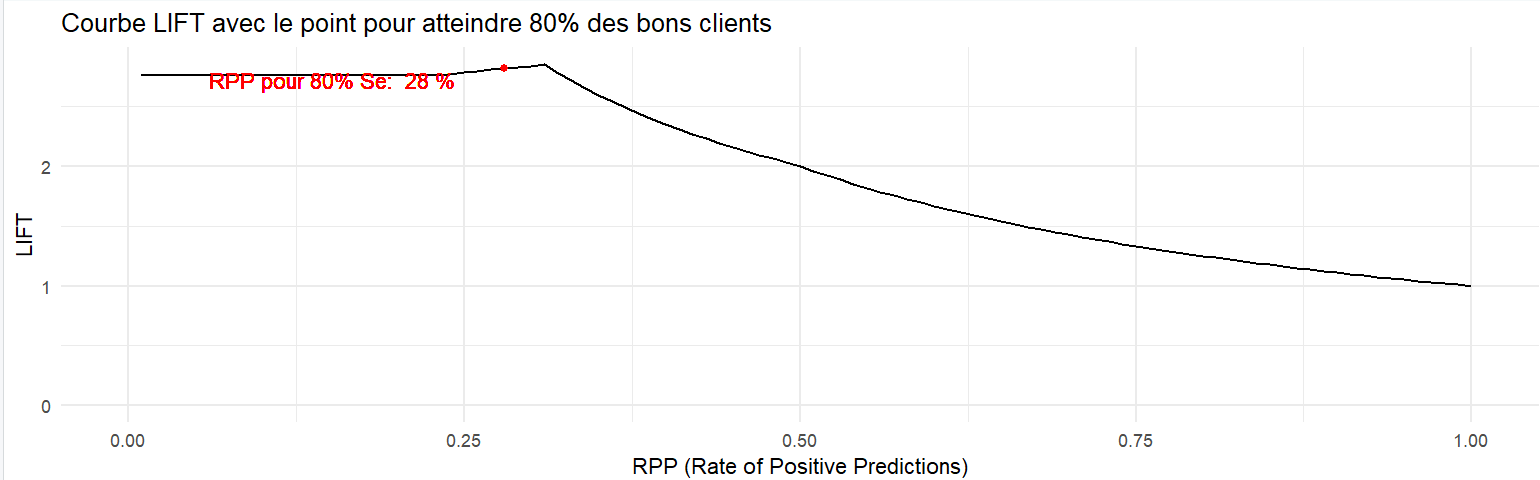

**Analyse**

Le point rouge indique le RPP requis pour atteindre 80% des bons clients. Il est placé à 28% sur l'axe RPP, ce qui signifie qu'en ciblant 28% des clients les plus susceptibles d'être bons selon le modèle, on peut s'attendre à capter environ 80% des bons clients réels. Ce point est essentiel car il détermine un seuil à partir duquel le modèle devient moins efficace pour capturer les bons clients - pour chaque client supplémentaire inclus au-delà de ce seuil, le modèle capture de moins en moins de bons clients.

Le LIFT à ce point est calculé comme le ratio entre la sensibilité observée à un certain seuil et le taux de cette sensibilité si la sélection était faite au hasard. Si le LIFT est supérieur à 1, cela signifie que le modèle fait mieux que le hasard. Sur cette courbe, nous ne voyons pas la valeur exacte du LIFT, mais le fait que le point soit au-dessus de la ligne de base (qui serait une ligne droite à 45 degrés si elle était tracée sur le graphique) suggère un LIFT supérieur à 1, indiquant ainsi une certaine efficacité du modèle.

# **PROBLEME IV :  Foret aléatoire, une application sur des données réelles**





Nous reprenons les étapes réalisées dans le TP afin de spliter les données que nous avons en ensemble d'entrainement et de test avec une répartition 70/30.
Les analyses préalables sont également les memes que celles réalisées lors du probleme 2.



> Installation des librairies nécessaires



In [ ]:
library(randomForest)
library(ranger)
library(pROC)



## **Implémentation de deux forets aleatoires**



> Choix des implémentations randomForest et Ranger



Dans le cadre de ce problème, deux implémentations de la méthode de forêt aléatoire sous R ont été expérimentées et comparées : le paquet 'randomForest' qui est une référence dans le domaine grâce à sa simplicité d'utilisation et à son efficacité reconnue, et le paquet 'ranger', connu pour sa rapidité et sa capacité à gérer de grands ensembles de données.



**> Random forest**



In [ ]:
#Réglage de l'hyperparamètre pour randomForest
tuneGridRandomForest <- expand.grid(mtry = 2:7)
fitControlRandomForest <- trainControl(method = "cv", number = 5, search = "grid")

#Entrainement
set.seed(123)
randomForestFit <- train(Diagnosis ~ ., data = trainData, method = "rf",
                         trControl = fitControlRandomForest, tuneGrid = tuneGridRandomForest)

#Prédictions
predictions_rf_raw <- predict(randomForestFit, newdata = testData)
predictions_rf_prob <- predict(randomForestFit, newdata = testData, type='prob')

Le choix de mtry, le nombre de variables à considérer pour chaque division dans une forêt aléatoire, influence la performance du modèle. Bien qu'une racine carrée du nombre de variables (environ 5 pour nos 30 variables prédictives) soit une bonne pratique courante pour les tâches de classification, nous explorons une plage plus large (de 2 à 7) pour garantir que nous ne manquons pas une configuration optimale qui pourrait mieux capturer les spécificités de notre ensemble de données.

La validation croisée à 5 plis est choisie pour évaluer le modèle Random Forest afin d'équilibrer efficacement la précision de l'estimation de la performance du modèle avec la complexité de calcul, tout en réduisant la variance des résultats et en adhérant aux pratiques conventionnelles qui se sont avérées efficaces pour une large gamme d'ensembles de données



In [ ]:
print(randomForestFit)
plot(randomForestFit)

*Random Forest*

*399 samples
 30 predictor
  2 classes: 'M', 'B'*

*No pre-processing*

*Resampling: Cross-Validated (5 fold)*

*Summary of sample sizes: 319, 319, 319, 319, 320*

*Resampling results across tuning parameters:*

  *mtry  Accuracy   Kappa    
  2     0.9498734  0.8916970
  3     0.9523734  0.8984983
  4     0.9523734  0.8984983
  5     0.9524051  0.8983131
  6     0.9524051  0.8983131
  7     0.9549051  0.9038273*

*Accuracy was used to select the optimal model using the largest value.*

*The final value used for the model was mtry = 7.*

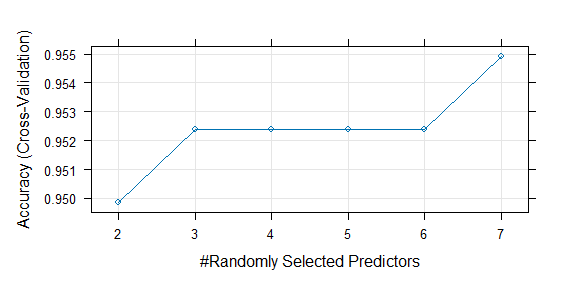

Dans cette sortie, le modèle Random Forest avec mtry = 7 a atteint la plus haute précision (95.49%) et la valeur kappa la plus élevée (0.9038), ce qui suggère que l'inclusion de sept variables aléatoires à chaque division dans la construction des arbres donne les meilleures prédictions en validation croisée sur cet ensemble de données.



**> Ranger**



In [ ]:
#Réglage de l'hyperparamètre pour ranger
tuneGridRanger <- expand.grid(mtry = c(2:7), splitrule = c("gini", "extratrees"), min.node.size = c(1, 5, 10))
fitControlRanger <- trainControl(method = "cv", number = 5, search = "grid")

#Entraînement du modèle avec ranger
set.seed(123)
rangerFit <- ranger(Diagnosis ~ ., data = trainData, num.trees = 200, mtry = 3, min.node.size = 1, importance = 'impurity')

#Prédiction sur le jeu de test pour ranger
predictions_ranger <- predict(object = rangerFit, data = testData, type = "response", num.threads = 1, verbose = TRUE)
predicted_labels <- predictions_ranger$predictions

#Obtenir les probabilites de prediction
rangerFit_prob <- ranger(Diagnosis ~ ., data = trainData, num.trees = 200, mtry = 3, min.node.size = 1, importance = 'impurity', probability = TRUE)
predictions_ranger_prob <- predict(object = rangerFit_prob, data = testData, type = "response", num.threads = 1, verbose = TRUE)

La grille d'hyperparamètres pour ranger évalue les combinaisons de mtry, splitrule, et min.node.size pour trouver le meilleur équilibre entre précision et généralisation, testant l'influence de la complexité du modèle et des règles de division sur les performances de classification. Cette approche exhaustive assure une optimisation rigoureuse et évite le surajustement en comparant des modèles avec différentes capacités de généralisation sur des données non vues.









> Optimisation des hyperparametres



Le modèle 'randomForest' n'a pas nécessité d'élagage car la méthode des forêts aléatoires réduit le surajustement en moyennant les résultats de plusieurs arbres. Pour 'ranger', l'attention a été portée sur la possibilité d'utiliser des fonctionnalités avancées pour affiner la construction des arbres et mieux gérer les données manquantes ou catégorielles.

## **Analyse et comparaison des erreurs de la classification**

> Matrice de confusion

In [ ]:
# Matrice de confusion pour randomForest
conf_matrix_rf <- confusionMatrix(predictions_rf_raw, testData$Diagnosis)
conf_matrix_rf

# Matrice de confusion pour ranger
conf_matrix_ranger <- confusionMatrix(predicted_labels, testData$Diagnosis)
conf_matrix_ranger

Bien que nos mos modeles soient differents et ne prédisent pas les classes avec les memes probabilites, nous avons des matrices de confusion identiques. Cela peut s'expliquer par le fait que nous avons des données tres distinctives et les différents parametres séparent tres bien les classes.

Le fait que les matrices de confusion peut venir de plusieurs facteurs :

*  Qualité des Données: Si l'ensemble de données est bien nettoyé, sans trop de bruit et avec des caractéristiques discriminantes fortes, il est probable que différents modèles de forêt aléatoire convergent vers des performances similaires.

*   Paramètres du Modèle: Si les hyperparamètres des deux modèles sont bien ajustés et optimisés, les deux implémentations peuvent atteindre leur potentiel de performance maximal, résultant en des matrices de confusion similaires.

*   Stabilité de l'Algorithme: Les forêts aléatoires sont conçues pour être stables, grâce à l'agrégation des prédictions de nombreux arbres de décision.

*   Taille et Complexité des Données: Dans les ensembles de données avec un nombre relativement faible de classes, ici nous en avons 2.

*   Séparation des Classes: Si les classes peuvent être facilement séparées à l'aide des variables explicatives.

In [ ]:
# Créer une nouvelle dataframe avec les prédictions et les vraies valeurs
comparison_df <- data.frame(
  TrueValue = testData$Diagnosis,
  RF_Prediction = predictions_rf_prob[,2],
  Ranger_Prediction = predictions_ranger_prob$predictions[,2] #çç
)

# Calculer un score de prédiction binaire basé sur un seuil, par exemple 0.5
comparison_df$RF_Class = ifelse(comparison_df$RF_Prediction > 0.5, "Positive", "Negative")
comparison_df$Ranger_Class = ifelse(comparison_df$Ranger_Prediction > 0.5, "Positive", "Negative")

# Créer une table de contingence pour comparer les classifications
table(comparison_df$RF_Class, comparison_df$Ranger_Class)

# Visualiser les prédictions avec un graphique à points
library(ggplot2)
ggplot(comparison_df, aes(x = RF_Prediction, y = Ranger_Prediction, color = TrueValue)) +
  geom_point(alpha = 0.5) +
  scale_color_manual(values = c("Positive" = "red", "Negative" = "blue")) +
  theme_minimal() +
  labs(title = "Comparaison des prédictions Random Forest vs Ranger",
       x = "Probabilité prédite Random Forest",
       y = "Probabilité prédite Ranger",
       color = "Valeur vraie")

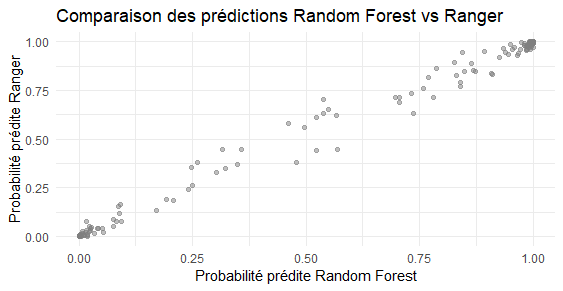

En observant le graphique, il est évident qu'il existe une corrélation positive entre les deux modèles, indiquant que, dans une large mesure, lorsque l'un des modèles prédit une probabilité plus élevée d'une classe, l'autre modèle tend à prédire également une probabilité plus élevée pour cette même classe.

Cependant, nous pouvons également noter des écarts entre les deux modèles, en particulier aux extrémités du spectre des probabilités. Par exemple, pour des probabilités prédites faibles par randomForest, ranger a tendance à prédire des probabilités légèrement plus élevées, et vice-versa pour les probabilités élevées. Cette tendance peut indiquer des différences dans la façon dont les modèles traitent les signaux plus faibles ou plus forts dans les données.

Le regroupement des points autour de la diagonale suggère une forte concordance entre les prédictions des deux modèles pour les probabilités intermédiaires. Néanmoins, les dispersions autour de cette ligne diagonale indiquent également que les modèles ne sont pas entièrement en accord, ce qui peut être attribuable aux différences dans les algorithmes sous-jacents, la sélection des caractéristiques, ou le traitement des données de la forêt aléatoire par randomForest et ranger.

En somme, bien que les deux implémentations présentent des prédictions globalement similaires, il y a suffisamment de divergence pour justifier une évaluation plus approfondie des cas où les prédictions diffèrent significativement.



> Courbes ROC et AUC



In [ ]:
#Calcul des courbes ROC pour chaque modele
probabilities_ranger <- predictions_ranger_prob$predictions[, "M"]
probabilities_rf <- predictions_rf_prob[, "M"]
roc_rf <- roc(response = testData$Diagnosis, predictor = probabilities_rf, levels = c("B", "M"))
roc_ranger <- roc(response = testData$Diagnosis, predictor = probabilities_ranger, levels = c("B", "M"))

#Calcul des AUC
auc_rf <- auc(roc_rf)
auc_ranger <- auc(roc_ranger)

#Traçage des courbes
plot(roc_rf, col = "red")
plot(roc_ranger, add = TRUE, col = "blue")
legend("bottomright", legend = c(paste("Random Forest, AUC :", round(auc_rf, digits = 3)), paste("Rager, AUC :", round(auc_ranger, digits = 3))), col = c("red", "blue"), lwd = 2)

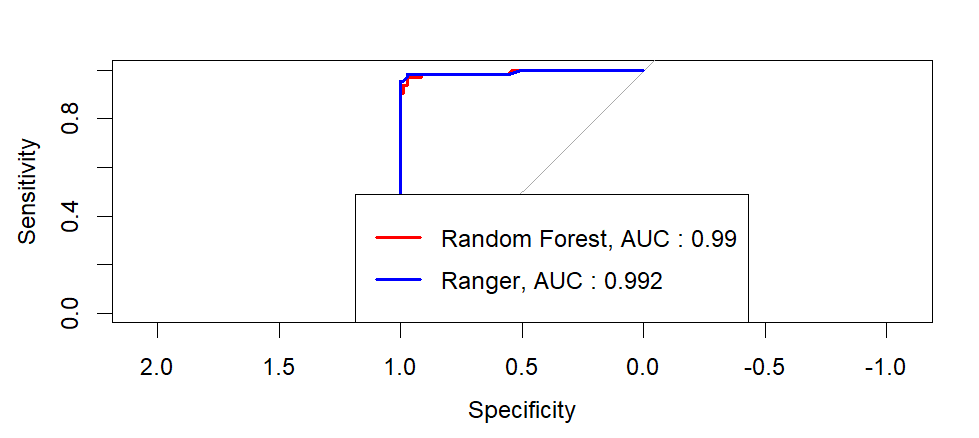

L'analyse des courbes ROC pour les implémentations Random Forest et Ranger démontre une excellente performance pour les deux modèles, avec des valeurs d'AUC respectives de 0.99 et 0.992. Ces valeurs, étant très proches de 1, indiquent une capacité presque parfaite des modèles à distinguer entre les différentes classes de l'ensemble de données. L'AUC étant une mesure globale de la performance du modèle, un score aussi élevé signifie que, indépendamment du seuil de classification choisi, les deux modèles sont capables de maintenir un équilibre remarquable entre la sensibilité (vrai positif) et la spécificité (vrai négatif).



> Calcul des métriques de précision et de rappel



In [ ]:
precision_rf <- conf_matrix_rf$byClass['Precision']
recall_rf <- conf_matrix_rf$byClass['Recall']
precision_ranger <- conf_matrix_ranger$byClass['Precision']
recall_ranger <- conf_matrix_ranger$byClass['Recall']

## **Interprétation des performances des différentes implémentations**



> Discussion AUC



La légère supériorité de l'AUC pour Ranger (0.992) par rapport à Random Forest (0.99) peut être attribuable à des optimisations algorithmiques spécifiques ou à une meilleure gestion des hyperparamètres dans l'implémentation Ranger. Néanmoins, la différence étant minime, il convient de noter que les deux modèles se comportent de manière quasi identique en termes de performance discriminatoire.

Ces résultats soulignent l'efficacité des forêts aléatoires en tant que technique de classification robuste et précise, capable de fournir des prédictions fiables et de qualité. Il est remarquable que les deux implémentations aient produit des résultats presque identiques, ce qui témoigne de leur compétence et de leur applicabilité à l'échantillon de données considéré.



> Importance des variables



In [ ]:
#Random Forest
importance_rf <- varImp(randomForestFit)
plot(importance_rf)

#Ranger
importance_ranger <- rangerFit$variable.importance
barplot(importance_ranger, main="Variable Importance - Ranger", las=2)

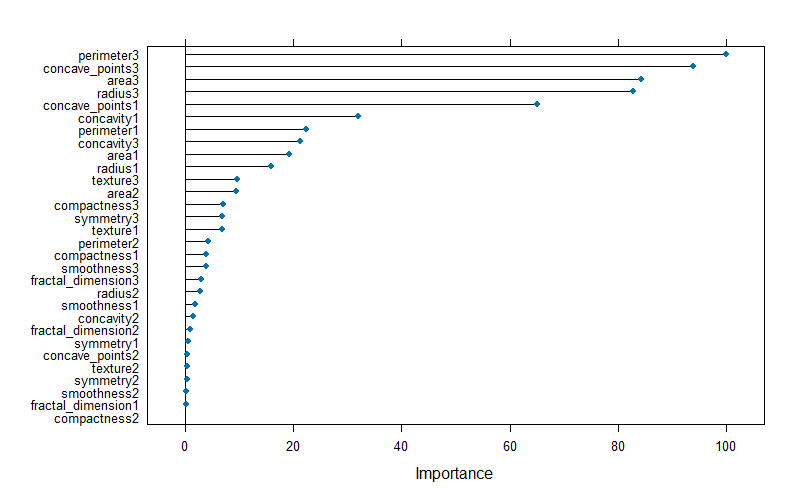

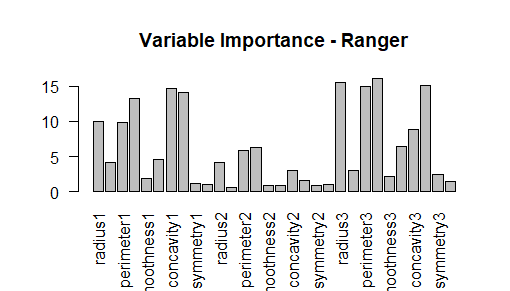

On retrouve en effet les memes parametres les plus importants. Par ailleurs, ce sont également ceux là que nous retrouvons dans l'arbre du probleme 2.



> Conclusion générale

Les modèles Random Forest et Ranger se sont avérés être des outils puissants et précis pour la classification des cellules bénignes ou malignes. En dépit de la légère différence dans les mesures d'AUC, les deux approches fournissent des performances de classification excellentes et sont soutenues par une évaluation cohérente des variables les plus influentes. L'efficacité, l'exactitude et la cohérence de ces modèles les rendent adaptés pour des applications dans le domaine de la recherche biomédicale et la pratique clinique où la distinction rapide et fiable entre tissus bénins et malins est cruciale.

Les résultats de ce TP mettent en évidence que la sélection entre Random Forest et Ranger peut être basée sur des préférences personnelles, des exigences de performance spécifiques ou des contraintes computationnelles, plutôt que sur une différence marquée de capacité entre les deux modèles. En somme, les praticiens et chercheurs peuvent choisir l'une ou l'autre méthode avec l'assurance d'obtenir des résultats de haute qualité pour la classification de données médicales complexes.


